In [5]:
# Install required packages
!pip install ultralytics
!pip install ray==2.0.0

# Import necessary libraries
from ultralytics import YOLO
import torch
import yaml
from pathlib import Path
import os

# Import ray and patch it to avoid the _get_session error in the callback
import ray
# Patch ray.train._internal.session if _get_session is missing
if not hasattr(ray.train._internal.session, "_get_session"):
    ray.train._internal.session._get_session = lambda: None

# Define absolute paths for Kaggle
DATASET_PATH = "/kaggle/input/wastet"

# Create data.yaml file with absolute paths
data_yaml = {
    'train': f"{DATASET_PATH}/train/images",
    'val': f"{DATASET_PATH}/valid/images",
    'test': f"{DATASET_PATH}/test/images",
    'nc': 4,
    'names': ['cap', 'paper', 'plastic', 'shell']
}

# Save the yaml file
with open('data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

# Verify the paths
print("Verifying paths:")
print(f"Train path exists: {os.path.exists(data_yaml['train'])}")
print(f"Validation path exists: {os.path.exists(data_yaml['val'])}")
print(f"Test path exists: {os.path.exists(data_yaml['test'])}")

# Print the content of data.yaml
print("\nContent of data.yaml:")
with open('data.yaml', 'r') as f:
    print(f.read())

# Verify GPU availability
print("\nGPU Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

# Initialize YOLOv8 model
model = YOLO('yolov8n.pt')

# Training configuration (note: the unsupported 'raytune' parameter has been removed)
args = {
    'data': str(Path('data.yaml').absolute()),  # Use absolute path
    'epochs': 50,
    'imgsz': 640,
    'batch': 8,
    'patience': 20,
    'device': 0,
    'workers': 2,
    'save': True,
    'cache': True,
    'project': 'waste_detection',
    'name': 'training_run',
    'exist_ok': True
}

# Train the model using keyword argument unpacking
try:
    print("\nStarting training...")
    results = model.train(**args)
    print("Training completed successfully!")
except Exception as e:
    print(f"An error occurred during training: {str(e)}")
    import traceback
    print(traceback.format_exc())

# Save the trained model
try:
    model.save('waste_detection_best.pt')
    print("\nModel saved successfully!")
except Exception as e:
    print(f"Error saving model: {str(e)}")

# Optional: Test the model on a few images
print("\nRunning test predictions...")
test_images_path = f"{DATASET_PATH}/test/images"
# Using '*.jpg' to match jpg files
test_images = list(Path(test_images_path).glob('*.jpg'))[:3]
for img_path in test_images:
    try:
        results = model.predict(str(img_path), save=True, conf=0.25)
        print(f"Processed: {img_path.name}")
    except Exception as e:
        print(f"Error processing {img_path.name}: {str(e)}")


Verifying paths:
Train path exists: True
Validation path exists: True
Test path exists: True

Content of data.yaml:
names:
- cap
- paper
- plastic
- shell
nc: 4
test: /kaggle/input/wastet/test/images
train: /kaggle/input/wastet/train/images
val: /kaggle/input/wastet/valid/images


GPU Available: True
GPU Name: Tesla T4

Starting training...
Ultralytics 8.3.73 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data.yaml, epochs=50, time=None, patience=20, batch=8, imgsz=640, save=True, save_period=-1, cache=True, device=0, workers=2, project=waste_detection, name=training_run, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_

train: Scanning /kaggle/input/wastet/train/labels... 7349 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7349/7349 [00:08<00:00, 889.54it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/wastet/train is not writeable, cache not saved.
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 8, len(boxes) = 12120. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (8.4GB RAM): 100%|██████████| 7349/7349 [00:10<00:00, 714.41it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/input/wastet/valid/labels... 526 images, 0 backgrounds, 0 corrupt: 100%|██████████| 526/526 [00:00<00:00, 752.42it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/wastet/valid is not writeable, cache not saved.
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.6GB RAM): 100%|██████████| 526/526 [00:00<00:00, 728.39it/s]


Plotting labels to waste_detection/training_run/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to waste_detection/training_run
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.58G     0.9228      1.839     0.9587          4        640: 100%|██████████| 919/919 [01:31<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.14it/s]


                   all        526       1164      0.487      0.467      0.435      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.23G     0.8168      0.941     0.9411          9        640: 100%|██████████| 919/919 [01:28<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.84it/s]


                   all        526       1164      0.502      0.552      0.464      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.23G     0.7822     0.7711     0.9308          9        640: 100%|██████████| 919/919 [01:27<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.63it/s]


                   all        526       1164      0.514      0.491      0.444      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.23G     0.7461     0.6958     0.9212         15        640: 100%|██████████| 919/919 [01:26<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.83it/s]


                   all        526       1164      0.553      0.585      0.515      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.23G      0.687     0.6167     0.9031          8        640: 100%|██████████| 919/919 [01:26<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.66it/s]

                   all        526       1164      0.592      0.571      0.563      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.23G     0.6632     0.5869        0.9          8        640: 100%|██████████| 919/919 [01:26<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.91it/s]

                   all        526       1164      0.555       0.56      0.515      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.23G      0.636     0.5465     0.8925         18        640: 100%|██████████| 919/919 [01:26<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.24it/s]

                   all        526       1164      0.665      0.536      0.552      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.22G     0.6231     0.5327     0.8854         12        640: 100%|██████████| 919/919 [01:26<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.71it/s]

                   all        526       1164      0.582      0.625      0.569      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.23G     0.6006     0.5072     0.8809         12        640: 100%|██████████| 919/919 [01:26<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.68it/s]

                   all        526       1164      0.602      0.605      0.568      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.23G     0.5844     0.4819     0.8761         15        640: 100%|██████████| 919/919 [01:26<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.73it/s]

                   all        526       1164      0.616      0.615      0.578      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.23G     0.5556     0.4672     0.8713         11        640: 100%|██████████| 919/919 [01:26<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.84it/s]

                   all        526       1164      0.585      0.668      0.576       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.23G     0.5601     0.4641     0.8708          6        640: 100%|██████████| 919/919 [01:26<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.68it/s]

                   all        526       1164      0.634      0.656      0.601      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.23G     0.5507     0.4565     0.8671         10        640: 100%|██████████| 919/919 [01:26<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.87it/s]

                   all        526       1164      0.508       0.65      0.542      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.23G     0.5339     0.4376      0.861         10        640: 100%|██████████| 919/919 [01:26<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.88it/s]

                   all        526       1164      0.623       0.56      0.553      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.23G     0.5213     0.4248     0.8619         11        640: 100%|██████████| 919/919 [01:26<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.75it/s]


                   all        526       1164      0.576      0.597       0.54      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.22G     0.5195     0.4216     0.8644          9        640: 100%|██████████| 919/919 [01:26<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.70it/s]

                   all        526       1164      0.604      0.611      0.572       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.23G      0.507     0.4099     0.8588         11        640: 100%|██████████| 919/919 [01:26<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.64it/s]

                   all        526       1164      0.605      0.591      0.557      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.23G     0.4959     0.3971     0.8525         20        640: 100%|██████████| 919/919 [01:26<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.57it/s]

                   all        526       1164      0.595      0.717      0.579      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.23G     0.4903     0.3889     0.8532          8        640: 100%|██████████| 919/919 [01:26<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.96it/s]

                   all        526       1164      0.633      0.645       0.62      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.23G     0.4826     0.3875     0.8535         16        640: 100%|██████████| 919/919 [01:26<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.81it/s]

                   all        526       1164      0.658      0.625      0.608      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.23G     0.4763     0.3793       0.85          8        640: 100%|██████████| 919/919 [01:26<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.81it/s]

                   all        526       1164       0.65      0.618      0.621      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.23G     0.4808     0.3767     0.8502         19        640: 100%|██████████| 919/919 [01:26<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.76it/s]

                   all        526       1164      0.594      0.672       0.59      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.23G     0.4633      0.364     0.8462         13        640: 100%|██████████| 919/919 [01:26<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.87it/s]

                   all        526       1164      0.604      0.685      0.619      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.22G     0.4628     0.3593     0.8466          4        640: 100%|██████████| 919/919 [01:26<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.47it/s]


                   all        526       1164      0.599      0.656      0.583       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.23G     0.4566     0.3598     0.8446         11        640: 100%|██████████| 919/919 [01:26<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.98it/s]

                   all        526       1164      0.634      0.649      0.601        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.23G     0.4443     0.3476      0.841         15        640: 100%|██████████| 919/919 [01:26<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.50it/s]

                   all        526       1164      0.616      0.651      0.608      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.23G     0.4406     0.3397     0.8412          7        640: 100%|██████████| 919/919 [01:26<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.73it/s]

                   all        526       1164      0.639      0.637      0.627      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.23G      0.435     0.3374     0.8407         20        640: 100%|██████████| 919/919 [01:26<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.79it/s]

                   all        526       1164      0.666       0.61      0.592      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.23G     0.4288     0.3314     0.8386          9        640: 100%|██████████| 919/919 [01:26<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.48it/s]

                   all        526       1164      0.612      0.665      0.598       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.23G     0.4309     0.3277      0.841         10        640: 100%|██████████| 919/919 [01:26<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.72it/s]

                   all        526       1164      0.612      0.689      0.607      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.23G     0.4234     0.3182     0.8369          7        640: 100%|██████████| 919/919 [01:26<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.62it/s]

                   all        526       1164      0.607      0.692      0.627      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.22G     0.4193     0.3136     0.8377         14        640: 100%|██████████| 919/919 [01:26<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.58it/s]

                   all        526       1164      0.611      0.663      0.616      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.23G     0.4081     0.3063     0.8338          9        640: 100%|██████████| 919/919 [01:26<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.73it/s]

                   all        526       1164      0.627      0.665      0.628      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.23G     0.4022     0.3058     0.8323         10        640: 100%|██████████| 919/919 [01:26<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.64it/s]

                   all        526       1164       0.61      0.681      0.618      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.23G     0.4026     0.3044     0.8341         10        640: 100%|██████████| 919/919 [01:26<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.12it/s]

                   all        526       1164      0.641      0.647      0.613      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.23G     0.3983     0.3021     0.8321          5        640: 100%|██████████| 919/919 [01:26<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.60it/s]

                   all        526       1164      0.684      0.647      0.637      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.23G     0.3938      0.293       0.83         15        640: 100%|██████████| 919/919 [01:26<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.82it/s]

                   all        526       1164      0.626      0.663       0.62      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.23G     0.3843     0.2897     0.8276          8        640: 100%|██████████| 919/919 [01:26<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.33it/s]


                   all        526       1164      0.642       0.65      0.612      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.23G     0.3854     0.2883     0.8297         13        640: 100%|██████████| 919/919 [01:26<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.83it/s]

                   all        526       1164      0.647      0.653      0.608      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.22G     0.3741     0.2788     0.8269         14        640: 100%|██████████| 919/919 [01:26<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.90it/s]

                   all        526       1164      0.642      0.675      0.631      0.436


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.23G     0.8626     0.5352     0.9406          6        640: 100%|██████████| 919/919 [01:25<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.66it/s]

                   all        526       1164      0.679      0.627      0.626      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.23G     0.8386     0.4926     0.9292          7        640: 100%|██████████| 919/919 [01:25<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.47it/s]

                   all        526       1164      0.648      0.665      0.632      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.23G     0.8273     0.4755     0.9231          7        640: 100%|██████████| 919/919 [01:25<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.71it/s]

                   all        526       1164      0.689      0.625      0.631      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.23G     0.8144     0.4504     0.9154         11        640: 100%|██████████| 919/919 [01:25<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.81it/s]

                   all        526       1164      0.675      0.679      0.647      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.23G     0.8037     0.4415     0.9099          8        640: 100%|██████████| 919/919 [01:25<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.08it/s]

                   all        526       1164      0.667      0.664      0.642      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.23G     0.7921     0.4245     0.9061          9        640: 100%|██████████| 919/919 [01:24<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.84it/s]

                   all        526       1164      0.689      0.655      0.641      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.23G     0.7815     0.4192     0.9002          5        640: 100%|██████████| 919/919 [01:25<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.70it/s]

                   all        526       1164      0.682      0.661      0.651      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.22G     0.7826     0.4187     0.9008          8        640: 100%|██████████| 919/919 [01:25<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.55it/s]

                   all        526       1164      0.706      0.652      0.644      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.23G     0.7726     0.4078     0.9001          8        640: 100%|██████████| 919/919 [01:25<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.52it/s]

                   all        526       1164      0.689      0.672      0.646      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.23G     0.7646        0.4     0.8939          7        640: 100%|██████████| 919/919 [01:24<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.77it/s]

                   all        526       1164      0.697      0.655      0.642       0.45



50 epochs completed in 1.255 hours.
Optimizer stripped from waste_detection/training_run/weights/last.pt, 6.2MB
Optimizer stripped from waste_detection/training_run/weights/best.pt, 6.2MB

Validating waste_detection/training_run/weights/best.pt...
Ultralytics 8.3.73 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.74it/s]


                   all        526       1164      0.685      0.657      0.652      0.458
                   cap        365        507      0.984      0.867       0.97      0.744
                 paper        212        285      0.766      0.471      0.591      0.375
               plastic         15         16      0.107      0.562      0.175      0.123
                 shell        132        356      0.882      0.728      0.871      0.589


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.3ms preprocess, 2.4ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to waste_detection/training_run
Training completed successfully!

Model saved successfully!

Running test predictions...

image 1/1 /kaggle/input/wastet/test/images/video_20230131_145854_00029_jpg.rf.f428da97cd4bdd9ef7419c04f1d8dcaf.jpg: 640x640 2 caps, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to waste_detection/training_run
Processed: video_20230131_145854_00029_jpg.rf.f428da97cd4bdd9ef7419c04f1d8dcaf.jpg

image 1/1 /kaggle/input/wastet/test/images/video_20230131_152128_00032_jpg.rf.c736e9e4500d247d2185657f36d04619.jpg: 640x640 1 plastic, 7.4ms
Speed: 1.5ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to waste_detection/training_run
Processed: video_20230131_152128_00032_jpg.rf.c736e9e4500d247d2185657f36d04619.jpg

image 1/1 /kaggle/input/wastet/test/images/video_20


image 1/1 /kaggle/input/imagetes/video_20230131_145825_00029_jpg.rf.4e4709b4880012206f6ecd0a4f26465b.jpg: 640x640 1 cap, 1 shell, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


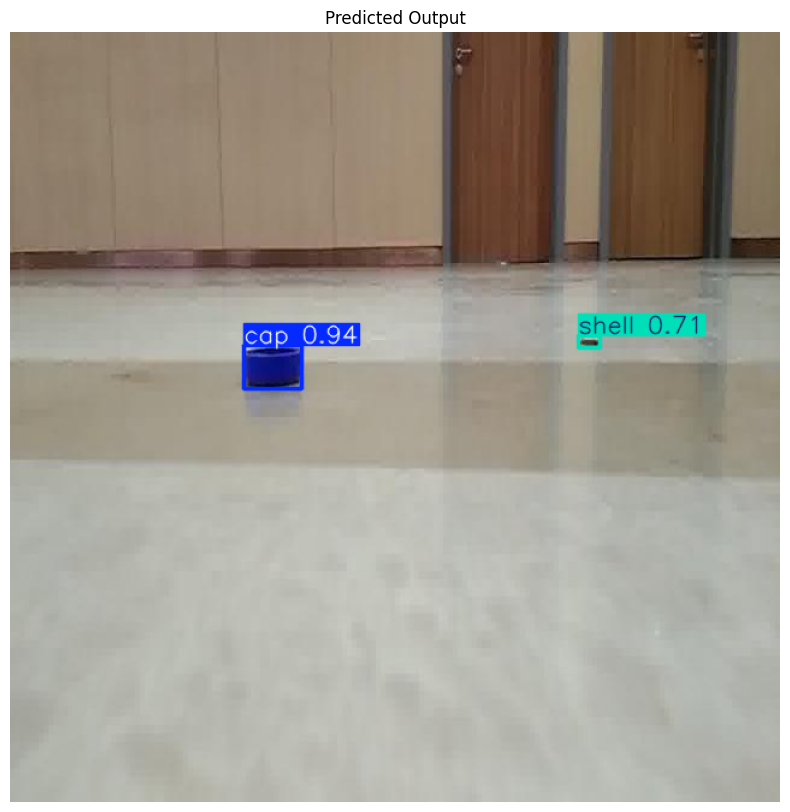

Detection details:
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0., 3.], device='cuda:0')
conf: tensor([0.9387, 0.7090], device='cuda:0')
data: tensor([[194.0624, 260.6434, 242.9793, 296.5588,   0.9387,   0.0000],
        [472.4894, 252.5881, 490.5582, 262.3438,   0.7090,   3.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (640, 640)
shape: torch.Size([2, 6])
xywh: tensor([[218.5208, 278.6011,  48.9169,  35.9154],
        [481.5238, 257.4660,  18.0688,   9.7557]], device='cuda:0')
xywhn: tensor([[0.3414, 0.4353, 0.0764, 0.0561],
        [0.7524, 0.4023, 0.0282, 0.0152]], device='cuda:0')
xyxy: tensor([[194.0624, 260.6434, 242.9793, 296.5588],
        [472.4894, 252.5881, 490.5582, 262.3438]], device='cuda:0')
xyxyn: tensor([[0.3032, 0.4073, 0.3797, 0.4634],
        [0.7383, 0.3947, 0.7665, 0.4099]], device='cuda:0')


In [6]:
import cv2
import matplotlib.pyplot as plt

# Specify the path to your input image
input_image_path = "/kaggle/input/imagetes/video_20230131_145825_00029_jpg.rf.4e4709b4880012206f6ecd0a4f26465b.jpg"  # Update with your image path

# Run the model prediction on the input image
# You can adjust the confidence threshold (e.g., conf=0.25) as needed
results = model.predict(source=input_image_path, conf=0.25, show=False)

# The 'results' object is a list; for a single image, we access the first element.
result = results[0]

# Get the annotated image (with bounding boxes and labels) from the result.
# The 'plot()' method returns the annotated image.
annotated_image = result.plot()

# Display the annotated image using matplotlib
plt.figure(figsize=(10, 10))
# OpenCV uses BGR by default, so we convert it to RGB for correct display
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Predicted Output")
plt.show()

# Optionally, print the detection details such as bounding boxes, classes, and confidence scores.
print("Detection details:")
print(result.boxes)


In [8]:
!pip install streamlit ultralytics opencv-python-headless pillow

import streamlit as st
from ultralytics import YOLO
from PIL import Image
import tempfile

# Title and description for the app
st.title("Waste Object Detection with YOLOv8")
st.write("Upload an image to see the detection results.")

# File uploader for image input
uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Open and display the uploaded image
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image', use_column_width=True)

    # Button to trigger prediction
    if st.button("Predict"):
        # Save the uploaded image to a temporary file so that it can be read by the YOLO model
        with tempfile.NamedTemporaryFile(suffix=".jpg", delete=False) as tmp_file:
            image.save(tmp_file.name)

            # Load the YOLO model (adjust the model path as necessary)
            # If you have a saved model, use that. Otherwise, you can use a pretrained model.
            model = YOLO('/kaggle/working/waste_detection_best.pt')

            # Run the prediction. You can adjust the confidence threshold if needed.
            results = model.predict(source=tmp_file.name, conf=0.25, save=False)

        # Get the annotated image from the prediction result.
        # The `plot()` method returns the image with bounding boxes and labels.
        annotated_image = results[0].plot()

        # Display the annotated image
        st.image(annotated_image, caption="Prediction Output", use_column_width=True)

        # Optionally, display detection details (e.g., bounding boxes, class scores, etc.)
        st.write("Detection details:")
        st.write(results[0].boxes)


2025-02-09 09:38:43.344 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-09 09:38:43.345 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-09 09:38:43.346 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-09 09:38:43.347 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-09 09:38:43.348 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-09 09:38:43.348 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-09 09:38:43.349 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-09 09:38:43.350 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

Columns in results.csv: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


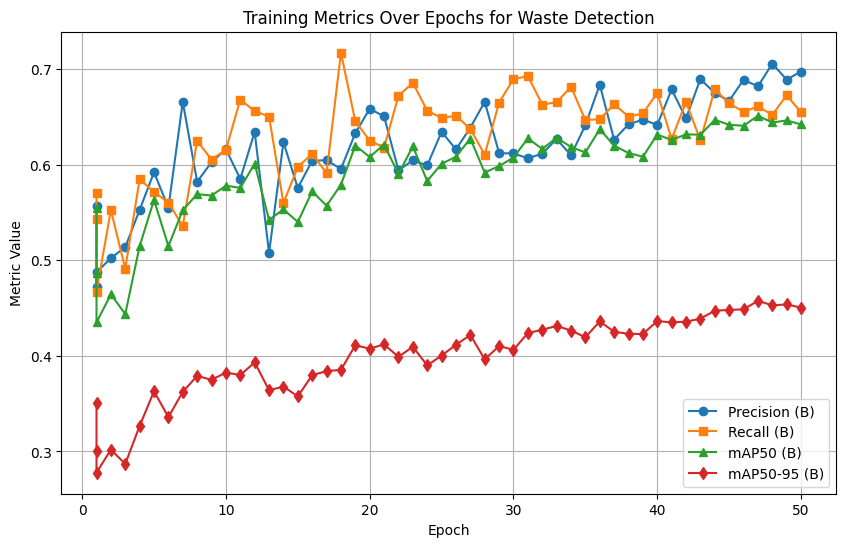

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load training results from CSV
results_df = pd.read_csv('/kaggle/working/waste_detection/training_run/results.csv')

# Print available columns to verify the structure
print("Columns in results.csv:", results_df.columns.tolist())

# Create a figure to plot the metrics
plt.figure(figsize=(10, 6))

# Plot Precision, Recall, mAP50, and mAP50-95 over epochs using the corresponding columns
plt.plot(results_df['epoch'], results_df['metrics/precision(B)'], label='Precision (B)', marker='o')
plt.plot(results_df['epoch'], results_df['metrics/recall(B)'], label='Recall (B)', marker='s')
plt.plot(results_df['epoch'], results_df['metrics/mAP50(B)'], label='mAP50 (B)', marker='^')
plt.plot(results_df['epoch'], results_df['metrics/mAP50-95(B)'], label='mAP50-95 (B)', marker='d')

# Customize the plot
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Training Metrics Over Epochs for Waste Detection')
plt.legend()
plt.grid(True)
plt.show()
